In this project, I aim to classify products into different categories using Convolutional Neural Networks (CNNs). The dataset was collected from the Slash application and consists of various product images across different categories. I divided the dataset into training and testing sets and performed preprocessing to prepare the images for model training.


My goal is to explore the effectiveness of different CNN architectures for product classification. I implemented several CNN models and evaluated their performance on the test dataset. Additionally, I applied techniques such as data augmentation, regularization, and early stopping to improve model accuracy and prevent overfitting.


Throughout this project, I will walk through the process of data preprocessing, model development, training, evaluation, and optimization, aiming to build a robust product classification system using deep learning techniques.

## Import Important libraries

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import os
import re
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalMaxPool2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from tensorflow.keras import layers, models, regularizers, optimizers, losses

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

The preprocessing steps applied to the images include:

1- Resizing: The images are resized to a specified target size (150, 150). This ensures that all images have the same dimensions, which is a common requirement for training deep learning models.

2- Normalization: The pixel values of the images are rescaled to the range [0, 1] using the rescale=1 / 255 parameter in the ImageDataGenerator. Normalization helps in stabilizing the training process and improving convergence by ensuring that the input data has a similar scale.

3- Data Augmentation: Various data augmentation techniques are applied to increase the diversity of the training data and improve the robustness of the model. These techniques include rotation, width and height shifting, zooming, and horizontal flipping. Data augmentation helps prevent overfitting and allows the model to learn more generalized features from the training data.

In [40]:
def Train_data_preprocessing_(path, batch_size=32, target_size=(150, 150)):
    """
    Preprocesses training data by applying data augmentation techniques.

    Parameters:
    - path: The directory path containing class-wise subdirectories of images.
    - batch_size: The batch size used for loading images.
    - target_size: The target size to which all images are resized during preprocessing.

    Returns:
    - train_dataset: A data generator for the training dataset.
    - validation_dataset: A data generator for the validation dataset.
    """

    # Get the list of class directories
    class_directories = [os.path.join(path, cls) for cls in os.listdir(path) if os.path.isdir(os.path.join(path, cls))]

    for class_dir in class_directories:
        print(f"Class: {os.path.basename(class_dir)}")

        # Count images before augmentation
#         before_augmentation_count = len(os.listdir(class_dir))
#         print(f"Number of images before augmentation: {before_augmentation_count}")

        # Define an image generator with augmentation parameters
        image_generator = ImageDataGenerator(
            rescale=1 / 255,
            rotation_range=10,
            width_shift_range=0.2,
            height_shift_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            validation_split=0.2  # Split data into training and validation sets
        )

        # Generate training dataset from the directory
        train_dataset = image_generator.flow_from_directory(
            batch_size=batch_size,
            directory=path,
            shuffle=True,
            target_size=target_size,
            subset="training",  # Subset of data used for training
            class_mode='categorical'  # Use categorical mode for multi-class classification
        )

        # Generate validation dataset from the directory
        validation_dataset = image_generator.flow_from_directory(
            batch_size=batch_size,
            directory=path,
            shuffle=True,
            target_size=target_size,
            subset="validation",  # Subset of data used for validation
            class_mode='categorical'  # Use categorical mode for multi-class classification
        )

        # Count images after augmentation
        after_augmentation_count = len(train_dataset.filenames)
#         print(f"Number of images after augmentation: {after_augmentation_count}")
#         print("////////////////////////////////////////////////////////////////////////////////")

    return train_dataset, validation_dataset

train_path = "M:/Self Study/Slash/Dataset/Train"
train_data, val_data = Train_data_preprocessing_(train_path)

Class: Accessories
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Artifacts
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Beauty
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Fashion
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Games
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Home
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Nutrition
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.
Class: Stationary
Found 285 images belonging to 8 classes.
Found 67 images belonging to 8 classes.


# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

The preprocessing steps applied to the test dataset:

1- Resizing: Similar to the training and validation datasets, the images in the test dataset are resized to (150, 150).

2- Normalization: The pixel values of the images are rescaled to the range [0, 1] using the rescale=1 / 255 parameter. This normalization ensures that the input data has a similar scale to the data used during training and validation.

In [41]:
def Test_data_preprocessing(path, batch_size=32, target_size=(150, 150)):
    """
    Preprocesses the test dataset for evaluation by resizing and normalizing the images.

    Args:
    - path (str): Path to the directory containing the test images.
    - batch_size (int): Batch size for generating batches of preprocessed images.
    - target_size (tuple): Tuple specifying the target size (height, width) to resize the images.

    Returns:
    - test_dataset (DirectoryIterator): Preprocessed test dataset iterator.
    """
    # Create an ImageDataGenerator instance for preprocessing
    image_generator = ImageDataGenerator(rescale=1 / 255)

    # Generate batches of preprocessed images from the test directory
    test_dataset = image_generator.flow_from_directory(
        batch_size=batch_size,
        directory=path,
        shuffle=False,  # Set shuffle to False for the test dataset
        target_size=target_size,
        class_mode='categorical'
    )

    return test_dataset
test_path = "M:/Self Study/Slash/Dataset/Test"
test_data = Test_data_preprocessing(test_path)

Found 352 images belonging to 8 classes.


# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

This function takes model function as input. It trains the specified model using the training data, plots the training history, evaluates the model on the test data, and returns the trained model. The model function passed as an argument should return a compiled Keras model.

In [42]:
def train_evaluate_model(model_function, epochs=100):
    """
    Train and evaluate a CNN model using the given training and test data paths and the specified model function.

    Args:
    - model_function (function): Function that returns a compiled Keras model.
    - epochs (int): Number of epochs for training the model. Default is 100.

    Returns:
    - model: Trained Keras model.
    """
    
    # Build and train the model
    model = model_function(train_data, val_data, epochs)

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(model.history.history['accuracy'], label='Training Accuracy')
    plt.plot(model.history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(model.history.history['loss'], label='Training Loss')
    plt.plot(model.history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(test_data)
    print(f'Test accuracy: {test_accuracy * 100:.2f}%')

    return model


# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## let's start with first model architecture

In [43]:
def cnn_model_1(train_data, val_data, epochs):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu',  input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(8, activation='softmax'))

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    model_checkpoint = ModelCheckpoint('model_1.keras', monitor='val_loss', save_best_only=True)


    print("Start training...")
    model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping, model_checkpoint])
    print("Finished training...")

    return model


Start training...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 778ms/step - accuracy: 0.2215 - loss: 2.0718 - val_accuracy: 0.2985 - val_loss: 1.9992
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 12s 593ms/step - accuracy: 0.2868 - loss: 1.8971 - val_accuracy: 0.2836 - val_loss: 1.9846
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 696ms/step - accuracy: 0.2470 - loss: 1.8540 - val_accuracy: 0.2687 - val_loss: 1.9062
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 855ms/step - accuracy: 0.3164 - loss: 1.8902 - val_accuracy: 0.3134 - val_loss: 1.9089
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 878ms/step - accuracy: 0.3027 - loss: 1.8194 - val_accuracy: 0.2836 - val_loss: 1.7924
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 617ms/step - accuracy: 0.2864 - loss: 1.8514 - val_accuracy: 0.3134 - val_loss: 1.9159
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 684ms/step - accuracy: 0.2950 - loss: 1.8532 - val_accuracy: 0.2836 - val_loss: 1.8037
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 13s 714ms/step - accuracy: 0.3101 - loss: 1.7936 

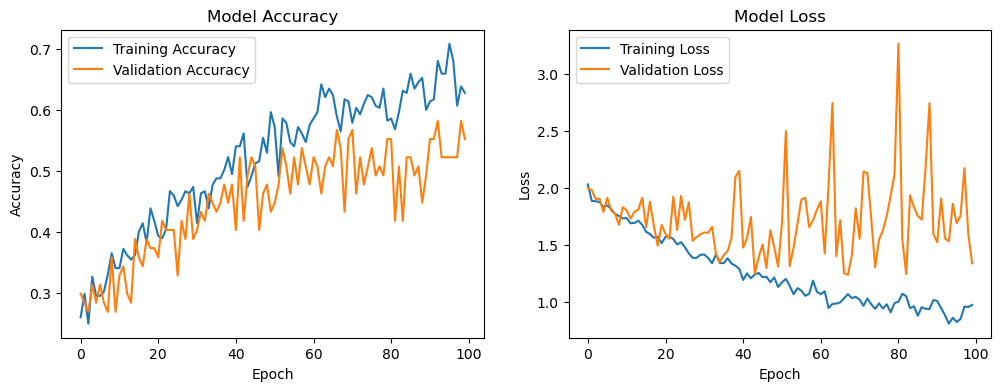

11/11 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.5796 - loss: 1.1953
Test accuracy: 67.61%


<Sequential name=sequential_3, built=True>

In [44]:
train_evaluate_model(cnn_model_1, epochs=100)

# /////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## let's try another one

In [50]:
def simple_cnn_model(train_data, val_data, epochs):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))

    model.add(layers.Dense(8, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint('simple_model.keras', monitor='val_loss', save_best_only=True)

    print("Start training...")
    history = model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping, model_checkpoint])
    print("Finished training...")

    return model


Start training...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 18s 940ms/step - accuracy: 0.2292 - loss: 2.3727 - val_accuracy: 0.2985 - val_loss: 1.9921
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 907ms/step - accuracy: 0.2691 - loss: 1.9850 - val_accuracy: 0.2985 - val_loss: 1.9770
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 787ms/step - accuracy: 0.2387 - loss: 1.9673 - val_accuracy: 0.2985 - val_loss: 1.9313
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 822ms/step - accuracy: 0.2518 - loss: 1.9023 - val_accuracy: 0.3134 - val_loss: 1.7676
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 840ms/step - accuracy: 0.2914 - loss: 1.9309 - val_accuracy: 0.2836 - val_loss: 1.8220
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 19s 907ms/step - accuracy: 0.2919 - loss: 1.8367 - val_accuracy: 0.3134 - val_loss: 1.8250
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2626 - loss: 1.8604 - val_accuracy: 0.3134 - val_loss: 1.9866
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 749ms/step - accuracy: 0.2998 - loss: 1.9145 - v

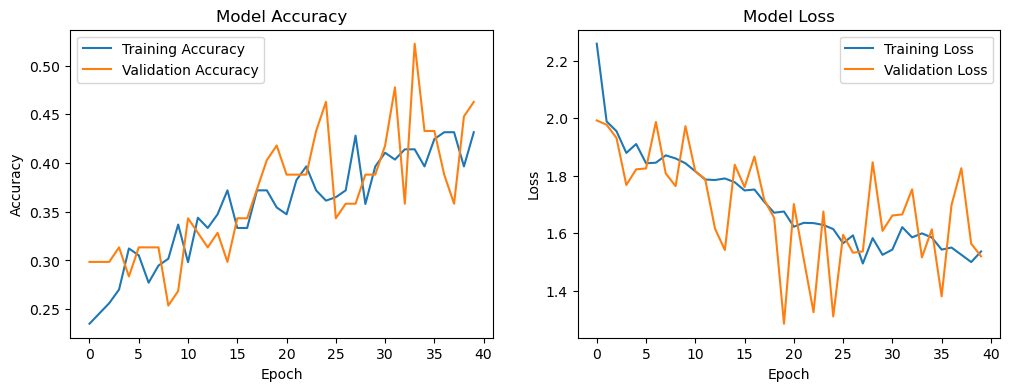

11/11 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.3486 - loss: 1.6464
Test accuracy: 45.17%


<Sequential name=sequential_6, built=True>

In [51]:
train_evaluate_model(simple_cnn_model, epochs=100)

# ////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

## let's make it more complex 

In [45]:
def cnn_model_2(train_data, val_data, epochs):
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())


    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())


    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(BatchNormalization())
 

    model.add(Conv2D(256, (3, 3)))
    model.add(GlobalMaxPool2D())

    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))



    model.add(Dense(8, activation='softmax'))
    

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

    model_checkpoint = ModelCheckpoint('model_1.keras', monitor='val_loss', save_best_only=True)


    print("Start training...")
    model.fit(train_data, epochs=epochs, validation_data=val_data, callbacks=[early_stopping, model_checkpoint])
    print("Finished training...")

    return model


Start training...
Epoch 1/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 17s 702ms/step - accuracy: 0.1465 - loss: 2.1799 - val_accuracy: 0.1642 - val_loss: 2.0775
Epoch 2/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 491ms/step - accuracy: 0.1746 - loss: 1.9978 - val_accuracy: 0.1493 - val_loss: 2.0345
Epoch 3/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.2462 - loss: 1.8315 - val_accuracy: 0.1493 - val_loss: 1.9922
Epoch 4/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 494ms/step - accuracy: 0.3432 - loss: 1.6645 - val_accuracy: 0.1940 - val_loss: 1.9920
Epoch 5/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 478ms/step - accuracy: 0.4569 - loss: 1.5704 - val_accuracy: 0.1493 - val_loss: 2.2326
Epoch 6/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 485ms/step - accuracy: 0.4612 - loss: 1.4467 - val_accuracy: 0.1940 - val_loss: 2.7496
Epoch 7/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step - accuracy: 0.4989 - loss: 1.3164 - val_accuracy: 0.1940 - val_loss: 2.9351
Epoch 8/100
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 489ms/step - accuracy: 0.4946 - loss: 1.3779 

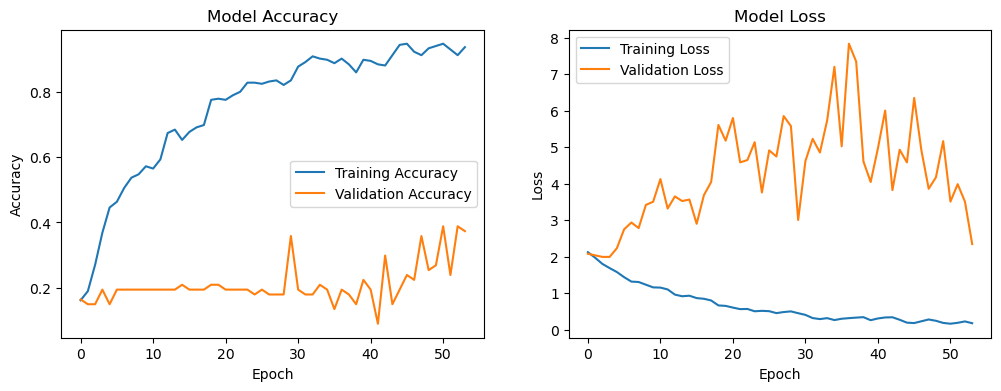

11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 828ms/step - accuracy: 0.3363 - loss: 1.8425
Test accuracy: 18.18%


<Sequential name=sequential_4, built=True>

In [46]:
train_evaluate_model(cnn_model_2, epochs=100)

As we can see When dealing with a small dataset, using a more complex model can lead to overfitting, where the model learns to memorize the training examples rather than generalize well to unseen data. This often results in reduced performance on the validation or test set.